# main.py

In [1]:
'''
File : Main notebook
Author : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois
Date : 06 déc 2023
Robot control and management of vision, global navigation, local navigation and Kalman filter.
'''

'\nFile : Main notebook\nAuthor : Jehan Corcelle, Raphaël Dousson, Arto Dubuisson, Benoît Gallois\nDate : 06 déc 2023\nRobot control and management of vision, global navigation, local navigation and Kalman filter.\n'

TO DO:

- mettre au propre les commentaires de l'étape 3

### Initialisations

In [2]:
# Import libraries
import time
from tdmclient import ClientAsync
import numpy as np
import math

# Import project files
import vision
import global_navigation as gn
import local_navigation as ln
import extended_Kalman_filter as eKf

In [3]:
# Connect to Thymio
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 328bdb70-11b8-49f9-b631-ac6519113084

In [4]:
# Robot's speed for a given task 
SPEED_STOP = 0
SPEED_FORWARD = 50
SPEED_TURN = 30
SPEED_BACKWARD = 50

SPEED_CORRECTION = 1 
SPEED_CONSTANT = 18.1818

# Proximity sensors thresholds
PROX_1_THRESHOLD = 4000
PROX_2_THRESHOLD = 2000
PROX_3_THRESHOLD = 1000
THRESHOLD_PROX_SENSOR = 20

# States of our finite-state-machine
ROTATION_STATE = 1
TRANSLATION_STATE = 2
CAMERA_STATE = 3
LOCAL_AVOIDANCE_STATE = 4

# Accuracy threshold when the robot thinks its arrived at a intermediate goal
TRANS_ACCURACY = 0.8
ROT_ACCURACY = 0.1
CHECK_ANGLE = math.pi / 2.0

# Convertion ratios
PIXEL_TO_CM_RATIO = 0.05406       
CM_TO_PIXEL_RATIO = 18.4971

In [5]:
# Set the motor speeds
async def stop_robot():
    '''
    @brief   Stop the robot. Set the motor speed of each wheel to zero.
    '''
    await node.set_variables({
            "motor.right.target": [SPEED_STOP],
            "motor.left.target": [SPEED_STOP],
        })

    
async def move_robot(right_speed, left_speed):
    '''
    @brief   Turn the robot wheels to the given speeds.

    @param   right_speed -> right wheel speed in [thymio speed]
             left_speed  -> left wheel speed in [thymio speed]
    '''
    await node.set_variables({
            "motor.right.target": [right_speed],
            "motor.left.target": [left_speed],
        })

In [6]:
# Get the proximity sensor values
async def get_prox_sensors():
    '''
    @brief   Get the sensor measurements of a the proximity sensors.

    @return  prox_sensors  -> numpy array of fron proximity sensors measurements
             detected      -> boolean = True if any sensors measured a higher value than threshold
    '''
    await node.wait_for_variables({str('prox.horizontal')})
    prox_sensors = np.asarray(list(node['prox.horizontal']))
    prox_sensors = prox_sensors[0:5]

    prox_sensors_bool = (prox_sensors >= np.array([PROX_1_THRESHOLD, PROX_2_THRESHOLD, PROX_3_THRESHOLD, 
                                                   PROX_2_THRESHOLD, PROX_1_THRESHOLD])) 
    detected = False
    if(any(prox_sensors_bool)):
        detected = True

    return prox_sensors, detected



# Get the motor speed measurement values
async def get_motor_speed_meas():
    '''
    @brief   Get the motor speed measurements.

    @return  speed_left_meas    -> left wheel speed in [thymio speed]
             speed_right_meas   -> right wheel speed in [thymio speed]
    '''
    
    await node.wait_for_variables({str('motor.right.speed')})
    speed_right_meas = node['motor.right.speed']
    await node.wait_for_variables({str('motor.left.speed')})
    speed_left_meas = node['motor.left.speed']

    return speed_right_meas, speed_left_meas

### Step 1: Check the connexion between the Thymio and the computer

In [7]:
await move_robot(SPEED_FORWARD, SPEED_FORWARD)
dt = 0
old_time = time.time()
while(dt < 2):
    y,d = await get_prox_sensors()
    await client.sleep(0.1)
    dt = time.time() - old_time
await stop_robot()

### Step 2: Detect the map with vision and global path planning

Coordonnées obstacles noirs : [[(549, 1080), (868, 1080), (868, 604), (549, 604)], [(1063, 1080), (1369, 1080), (1369, 614), (1063, 614)], [(0, 1080), (358, 1080), (358, 510), (0, 510)]]
Centroid de la goal area : [1631.   571.5]
Vecteur direction du robot : 94 -5
Centroid du robot : [470 571]


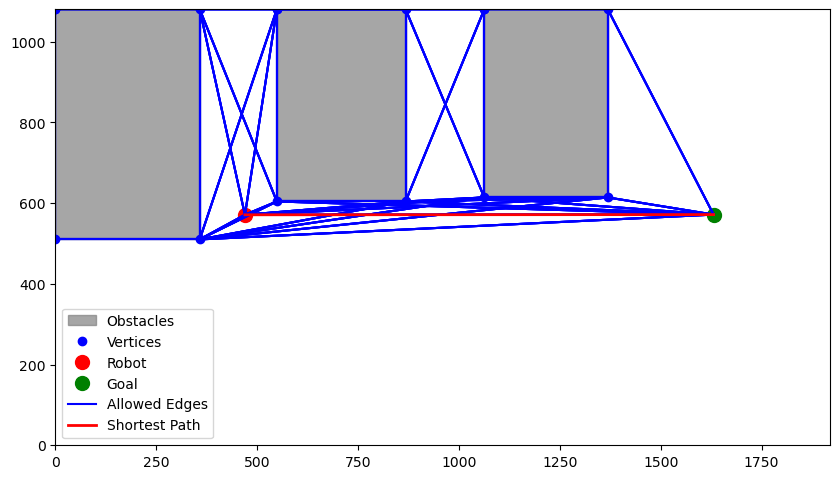

In [12]:
# Get the coordinates of the obstacles and the goal coordinates
obstacles, goal_centroid = vision.vision_obstacles_and_goal()
robot_centroid, robot_direction = vision.vision_robot()

# Get the robot initial position and its direction
while robot_centroid[0] == 0 and robot_centroid[1] == 0:
    robot_centroid, robot_direction = vision.vision_robot()

# Compute the shortest path with the global navigation
shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))

# Convert the cordinates of the goals and the robot position in centimeter
shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO)

### Step 3: Control the motors and check the robot position with an extended Kalman filter and use local avoidance if necessary

Iteration :  1
Kalman:  25.0 30.0 -0.053141408844935456
[-0.05314141] [0.] [0.05314141]
Iteration :  2
Kalman:  25.004811828462802 29.99974405167751 -0.05244193018173701
Translation state:
Error =  [62.99518817]
Iteration :  3
Kalman:  25.017544974964753 29.999075714064194 -0.047190496426959605
Translation state:
Error =  [62.98245503]
Iteration :  4
Kalman:  25.291288512234097 29.985679239524348 -0.043320444285701726
Translation state:
Error =  [62.70871312]
Iteration :  5
Kalman:  26.015033320230955 29.953413380227666 -0.03837909135489947
Translation state:
Error =  [61.98498419]
Iteration :  6
Kalman:  26.962749618671456 29.91853220063724 -0.03592382699992167
Translation state:
Error =  [61.03730475]
Iteration :  7
Kalman:  27.99058043579555 29.881781077157513 -0.036772023969340775
Translation state:
Error =  [60.00953601]
Iteration :  8
Kalman:  29.05751455874762 29.841894015345858 -0.03686469622279921
Translation state:
Error =  [58.94269749]
Iteration :  9
Kalman:  30.13562952073

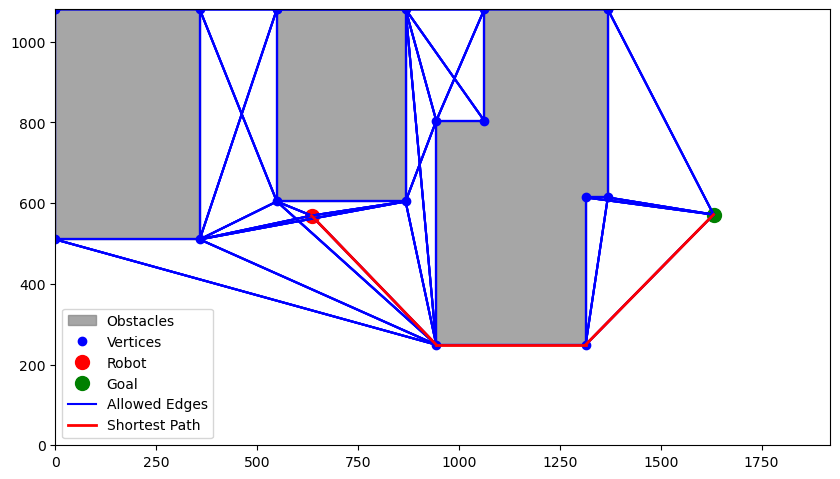

glob nav path : [(635.0, 569.0), (944.0, 249.0), (1314.0, 249.0), (1631.0, 571.5)]
camera measurements:  (34, 30) -0.23720679888364404
centroid camera:  (34, 30)
camera fin: [(51, 13), (71, 13), (88, 30)]
Iteration :  27
Kalman:  34.00066496336336 29.999992643896753 -0.23672592075827353
[-0.23672592] [-0.78541751] [-0.54869158]
Iteration :  28
Kalman:  32.985488063944345 30.24490889050347 -0.24705211723031173
[-0.24705212] [-0.76357475] [-0.51652263]
Iteration :  29
Kalman:  32.16214337397059 30.44999761504788 -0.26702599364158086
[-0.26702599] [-0.74717097] [-0.48014497]
Iteration :  30
Kalman:  31.75429809644912 30.55656088362193 -0.31813534741320876
[-0.31813535] [-0.7395326] [-0.42139726]
Iteration :  31
Kalman:  31.592999863363442 30.60997796094185 -0.3928084547103612
[-0.39280845] [-0.73689035] [-0.3440819]
Iteration :  32
Kalman:  31.527443714658475 30.637839871360455 -0.47862903082565683
[-0.47862903] [-0.73599897] [-0.25736994]
Iteration :  33
Kalman:  31.49747178786356 30.653

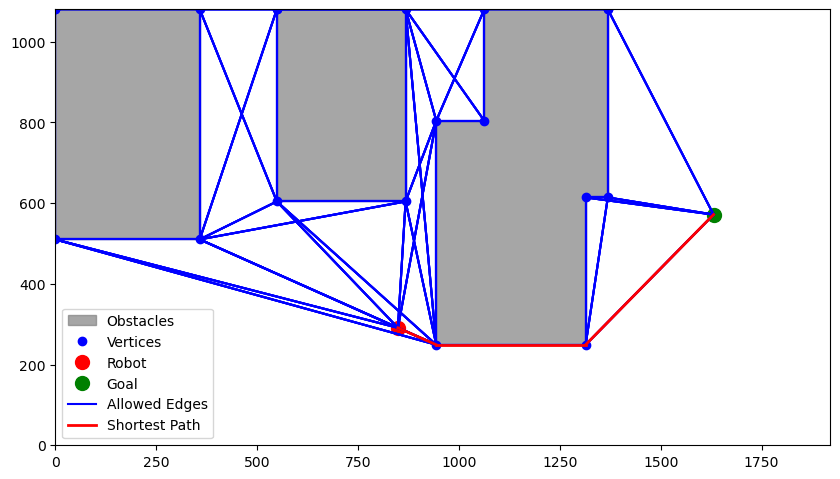

glob nav path : [(849.0, 291.0), (944.0, 249.0), (1314.0, 249.0), (1631.0, 571.5)]
camera measurements:  (45, 15) -0.8633647972289906
centroid camera:  (45, 15)
camera fin: [(51, 13), (71, 13), (88, 30)]
Iteration :  64
Kalman:  45.00046247669157 14.99945302288086 -0.8634621075186897
[-0.86346211] [-0.32169163] [0.54177048]
Iteration :  65
Kalman:  45.50901417238798 14.404601838853546 -0.8658968696231879
[-0.86589687] [-0.2504313] [0.61546557]
Iteration :  66
Kalman:  45.92416541885283 13.9083840346348 -0.8486784809492928
[-0.84867848] [-0.17708781] [0.67159067]
Iteration :  67
Kalman:  46.09049045535171 13.714791749666505 -0.7930768573796944
[-0.79307686] [-0.14457747] [0.64849939]
Iteration :  68
Kalman:  46.16348722071529 13.64109336364469 -0.7161012401696224
[-0.71610124] [-0.13178457] [0.58431668]
Iteration :  69
Kalman:  46.19356488123415 13.615798081488899 -0.6308196528096801
[-0.63081965] [-0.12742532] [0.50339434]
Iteration :  70
Kalman:  46.20585069427511 13.607241378560499 -

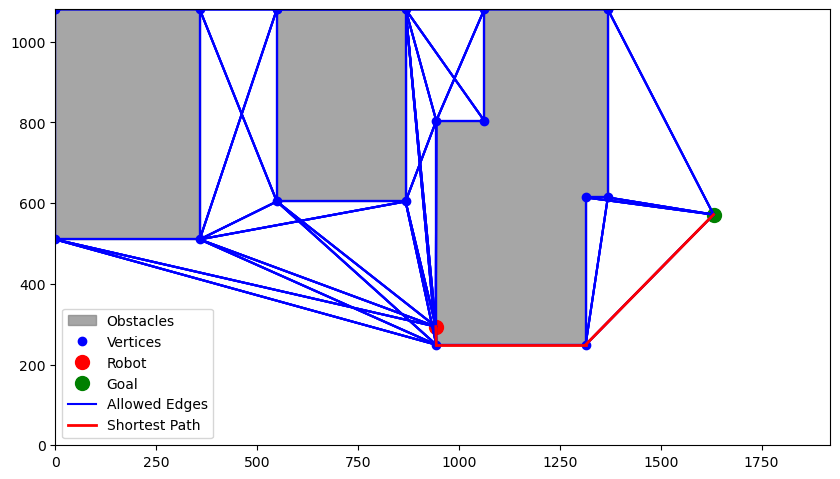

glob nav path : [(943.0, 294.0), (944.0, 249.0), (1314.0, 249.0), (1631.0, 571.5)]
camera measurements:  (50, 15) -0.14189705460416394
centroid camera:  (50, 15)
camera fin: [(71, 13), (88, 30)]
Iteration :  83
Kalman:  50.000633865493924 14.999904934528908 -0.1419052625363371
[-0.14190526] [-0.09495007] [0.04695519]
Iteration :  84
Kalman:  50.1918500217339 14.972588384332756 -0.14240773362213174
Translation state:
Error =  [20.90144039]
Iteration :  85
Kalman:  50.77863187632686 14.88805370528401 -0.13915957041162194
Translation state:
Error =  [20.30931992]
Iteration :  86
Kalman:  51.22380399833932 14.825789897853145 -0.13178122599674
Translation state:
Error =  [19.86029801]
Iteration :  87
Kalman:  52.02067774190942 14.719350576778924 -0.12572869105626705
Translation state:
Error =  [19.05704174]
Iteration :  88
Kalman:  53.00684090176336 14.595360978237405 -0.12083743007172609
Translation state:
Error =  [18.06374687]
Iteration :  89
Kalman:  54.03804125187414 14.470216222163826

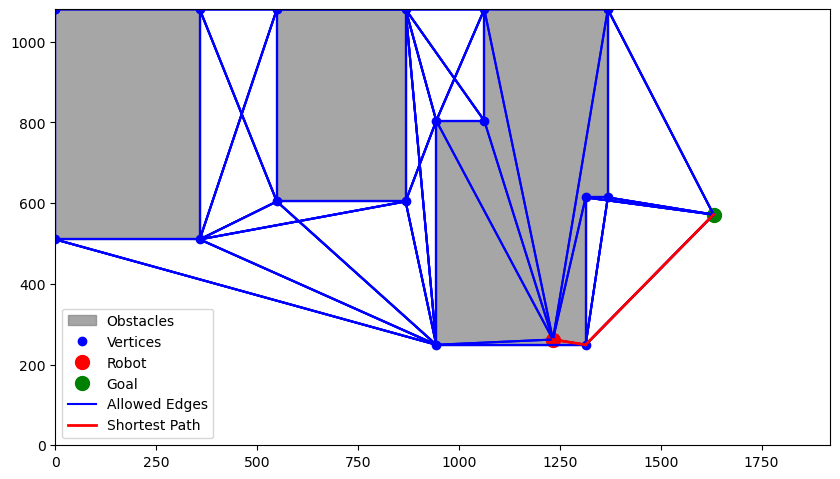

glob nav path : [(1233.0, 262.0), (1314.0, 249.0), (1631.0, 571.5)]
camera measurements:  (66, 14) -0.12927500404814304
centroid camera:  (66, 14)
camera fin: [(71, 13), (88, 30)]
Iteration :  107
Kalman:  66.00085941014899 13.999858754103006 -0.12969606950948828
[-0.12969607] [-0.19740145] [-0.06770538]
Iteration :  108
Kalman:  66.1834860034741 13.976040454654699 -0.12947555877487107
Translation state:
Error =  [4.9144137]
Iteration :  109
Kalman:  66.81299578653042 13.893976353275747 -0.1285319265151056
Translation state:
Error =  [4.28137805]
Iteration :  110
Kalman:  67.32386093129021 13.82818407974912 -0.12824808195370246
Translation state:
Error =  [3.76827379]
Iteration :  111
Kalman:  68.10636148257696 13.726894886576284 -0.12887580482832892
Translation state:
Error =  [2.98354153]
Iteration :  112
Kalman:  69.03226488536158 13.606700748439316 -0.12810356146284047
Translation state:
Error =  [2.05914237]
Iteration :  113
Kalman:  70.04177403144439 13.47655445744389 -0.12680928

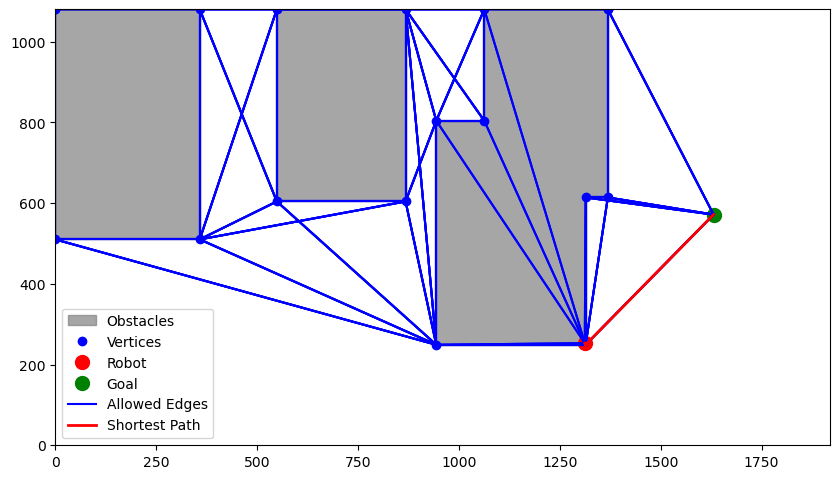

glob nav path : [(1312.0, 253.0), (1314.0, 249.0), (1631.0, 571.5)]
camera measurements:  (70, 13) -0.14048262839039768
centroid camera:  (70, 13)
camera fin: [(88, 30)]
Iteration :  116
Kalman:  70.00085978978643 13.000044785572543 -0.14008151949458347
[-0.14008152] [0.75685704] [0.89693855]
Iteration :  117
Kalman:  70.65576793668517 12.907691269276144 -0.14375815827625704
[-0.14375816] [0.77808271] [0.92184087]
Iteration :  118
Kalman:  71.23111716272794 12.818964976441421 -0.1219433932419955
[-0.12194339] [0.79753757] [0.91948097]
Iteration :  119
Kalman:  71.4416991125809 12.791344298692417 -0.06257583861642713
[-0.06257584] [0.80465588] [0.86723172]
Iteration :  120
Kalman:  71.51777287212114 12.786691951680393 0.01621444874238242
[0.01621445] [0.80709143] [0.79087698]
Iteration :  121
Kalman:  71.55078036667939 12.787504125539112 0.1047993259572275
[0.10479933] [0.80806918] [0.70326986]
Iteration :  122
Kalman:  71.57432269620419 12.79003276385846 0.19563597598797153
[0.19563598

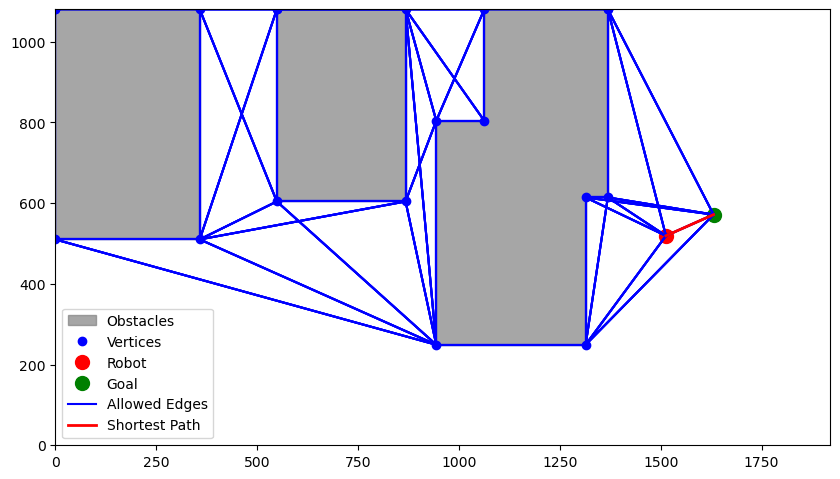

glob nav path : [(1513.0, 519.0), (1631.0, 571.5)]
camera measurements:  (81, 28) 0.8362018674556699
centroid camera:  (81, 28)
camera fin: [(88, 30)]
Iteration :  155
Kalman:  81.00046989763698 28.00056902171784 0.8362311424158771
[0.83623114] [0.27824223] [-0.55798891]
Iteration :  156
Kalman:  81.43307837386918 28.479548777925594 0.8376727196440108
[0.83767272] [0.22752274] [-0.61014997]
Iteration :  157
Kalman:  81.83816373056459 28.932893014855004 0.8286752240598512
[0.82867522] [0.17147923] [-0.65719599]
Iteration :  158
Kalman:  82.02601912128446 29.145581261744056 0.782569027767664
[0.78256903] [0.14205993] [-0.6405091]
Iteration :  159
Kalman:  82.0908109180291 29.210810391383937 0.7042778669563049
[0.70427787] [0.1327673] [-0.57151056]
Iteration :  160
Kalman:  82.10419129300868 29.221020715517472 0.614340869811955
[0.61434087] [0.13136338] [-0.48297749]
Iteration :  161
Kalman:  82.10286543444903 29.220160555789498 0.5217724240740946
[0.52177242] [0.13147754] [-0.39029489]
I

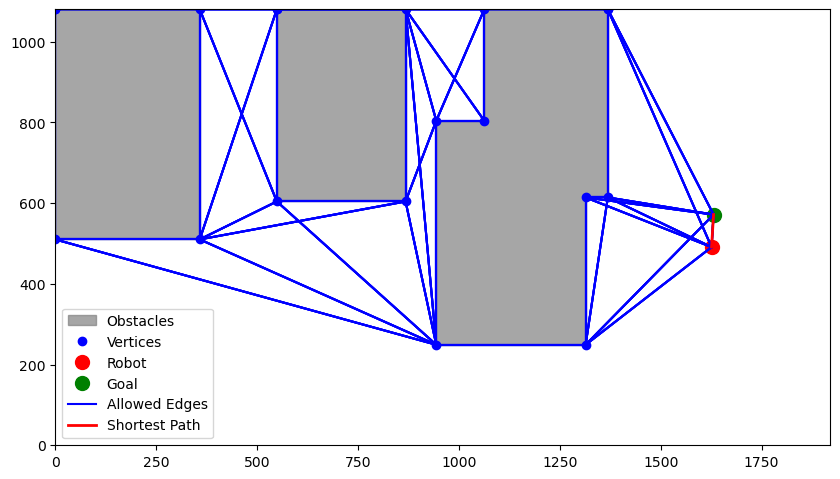

glob nav path : [(1626.0, 491.0), (1631.0, 571.5)]
camera measurements:  (87, 26) -0.08228798977468188
centroid camera:  (87, 26)
camera fin: [(88, 30)]
Iteration :  176
Kalman:  87.00062378442684 26.000168088691026 -0.08098302894363457
[-0.08098303] [1.32595456] [1.40693759]
Iteration :  177
Kalman:  87.34321567897162 25.972345793898445 -0.08614646847140675
[-0.08614647] [1.40915041] [1.49529688]
Iteration :  178
Kalman:  87.62990773297409 25.945415132215455 -0.06254127804545005
[-0.06254128] [1.47977109] [1.54231237]
Iteration :  179
Kalman:  87.76917851896671 25.935496811456435 -0.0011653506761481781
[-0.00116535] [1.51406767] [1.51523302]
Iteration :  180
Kalman:  87.83645111507022 25.93545596656327 0.07945576361907915
[0.07945576] [1.53058008] [1.45112432]
Iteration :  181
Kalman:  87.87408088287266 25.9389755820064 0.16714279916351318
[0.1671428] [1.53979952] [1.37265672]
Iteration :  182
Kalman:  87.89081315758435 25.942263742424043 0.258056154472355
[0.25805615] [1.5438945] [1.

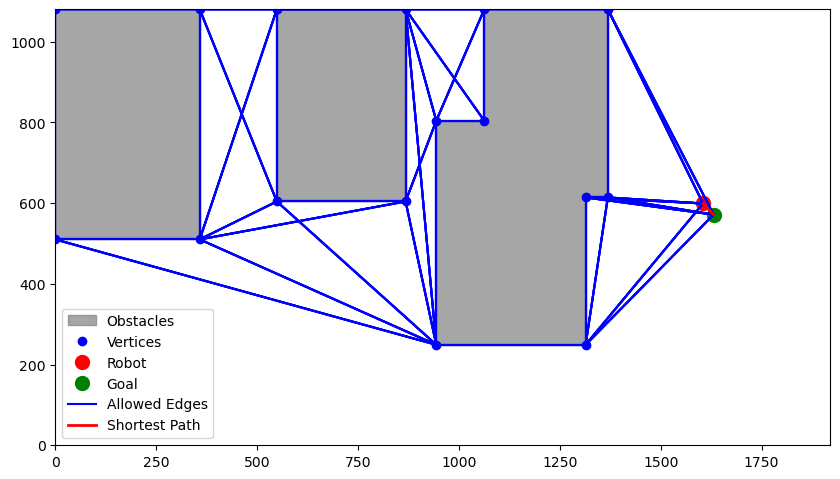

glob nav path : [(1605.0, 599.0), (1631.0, 571.5)]
camera measurements:  (86, 32) 1.5951817359676153
centroid camera:  (86, 32)
camera fin: []
Iteration :  204
Thymio arrived in the goal area, congratulations!


In [13]:
# Initial state
global_state = ROTATION_STATE

# Receive all the informations from the vision and global navigation
intermediate_goals = shortest_path
intermediate_goals.pop(0)
robot = [(robot_centroid[0],robot_centroid[1])]
robot_orientation = np.arctan2(robot_direction[1], robot_direction[0])
robot_speed = [0.0,0.0]

# Initialize the Kalman filter
Kfilter = eKf.Kalman(robot[0][0], robot[0][1], robot_orientation)


old_time = 0.0
printkal = True       # A VIRER
iter = 0


while(True):
    
    if iter == 0:                   
        old_time = time.time()
        
    dt = time.time() - old_time     # get time difference for Kalman -> A METTRE DANS UNE FONCTION
    old_time = time.time()

    Kfilter.dt_update(dt)
    Kfilter.Kalman_filter()
    
    iter = iter + 1
    print("Iteration : ", iter)

    # Check if the robot is arrived to the goal
    if intermediate_goals == []:
        await stop_robot()
        print("Thymio arrived in the goal area, congratulations!")
        break
    
    # Get robot sensor values
    prox_sensors, detected = await get_prox_sensors()
    
    # Prox sensors detect something, we call the local navigation
    if detected == True:
        await stop_robot()
        global_state = LOCAL_AVOIDANCE_STATE
        #continue

    #CA SERT A QUOI RAPH?
    speed_right_meas, speed_left_meas = await get_motor_speed_meas()
    speed_right_meas = speed_right_meas * SPEED_CORRECTION
    speed_left_meas = speed_left_meas * SPEED_CORRECTION
    Kfilter.measurement_wheels(speed_right_meas / SPEED_CONSTANT, speed_left_meas / SPEED_CONSTANT)
    

    if printkal:
        print("Kalman: ", Kfilter.Mu[0][0], Kfilter.Mu[1][0], Kfilter.Mu[2][0])
    
    robot.append((Kfilter.Mu[0][0], Kfilter.Mu[1][0]))
    
    if global_state == ROTATION_STATE:
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        print(Kfilter.Mu[2], np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]), angle)
        
        if(abs(angle) < ROT_ACCURACY):
            await stop_robot()
            global_state = TRANSLATION_STATE
            continue

        if(angle > 0):
            robot_speed = [SPEED_TURN, -SPEED_TURN]         # counterclockwise

        else:
            robot_speed = [-SPEED_TURN, SPEED_TURN]         # clockwise

            
    elif global_state == TRANSLATION_STATE:
        
        print("Translation state:")
        print("Error = ", np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2))
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            print("Thymio stopped while using the vision.")
            await stop_robot()
            global_state = CAMERA_STATE
            continue
            
        angle = np.arctan2(intermediate_goals[0][1] - Kfilter.Mu[1], intermediate_goals[0][0] - Kfilter.Mu[0]) - Kfilter.Mu[2]
        angle = eKf.center_angle(angle)
        
        
        robot_speed = [SPEED_FORWARD, SPEED_FORWARD]

        
        if abs(angle) > CHECK_ANGLE:
            await stop_robot()
            global_state = CAMERA_STATE
            continue
        
        
    elif global_state == CAMERA_STATE:
        robot_centroid = [0,0]
        while robot_centroid[0] == 0 and robot_centroid[1] == 0:
            robot_centroid, robot_direction = vision.vision_robot()
            
        merge_need = True
        visualize = True
        shortest_path, obstacles = gn.global_navigation(tuple(robot_centroid), obstacles, tuple(goal_centroid))
        print("glob nav path :", shortest_path)
        
        
        shortest_path = vision.converter(shortest_path, PIXEL_TO_CM_RATIO)
        robot_centroid = vision.converter(robot_centroid, PIXEL_TO_CM_RATIO) #changer pixel
        
        robot_angle = np.arctan2(robot_direction[1], robot_direction[0]) 
    
        Kfilter.measurement_position(robot_centroid[0], robot_centroid[1], robot_angle)
        print("camera measurements: ", robot_centroid, robot_angle)
        printkal = True
        
        intermediate_goals = shortest_path
        intermediate_goals.pop(0)
        
        if np.sqrt((intermediate_goals[0][0] - Kfilter.Mu[0])**2 + (intermediate_goals[0][1] - Kfilter.Mu[1])**2) <= TRANS_ACCURACY:
            intermediate_goals.pop(0)

        print("centroid camera: ", robot_centroid)
        print("camera fin:", shortest_path)
        
        global_state = ROTATION_STATE
        continue
        
        
        
    elif global_state == LOCAL_AVOIDANCE_STATE:
        print("local")
        robot_direction = (math.cos(Kfilter.Mu[2][0]), math.sin(Kfilter.Mu[2][0]))
        object_robot_coords = ln.object_robot_coordinates(prox_sensors)
        object_ground_coords = ln.robot_to_ground_coords([Kfilter.Mu[0][0], Kfilter.Mu[1][0]], robot_direction, object_robot_coords)
        
        if ln.is_inside(object_ground_coords, obstacles):
            continue

        Object = ln.safety_zone(object_ground_coords)
        Object = vision.converter(Object, CM_TO_PIXEL_RATIO)
    
        obstacles.append(Object)
        prox_sensors_bool = True
        
        while prox_sensors_bool:
            await move_robot(-SPEED_BACKWARD, -SPEED_BACKWARD)
            await client.sleep(2)
            prox_sensors, detected = await get_prox_sensors()
            prox_sensors_bool = any(prox_sensors >= np.ones(5) * THRESHOLD_PROX_SENSOR) 
            await client.sleep(0.4)
        
        global_state = CAMERA_STATE
        continue

        
        
    await move_robot(robot_speed[0], robot_speed[1])
    await client.sleep(0.3)


    

In [14]:
await stop_robot()